# Identifying the Highs of Closing Price

# Introduction

- Imports
- Grab data from Yahoo Finance
- Clean data and organize
- Set target - High Closing Prices (window days = 10-15)
- Baseline Model
- Optimized Model

# Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import numpy as np

import yfinance as yf
import datetime as dt
from datetime import date
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, roc_auc_score

from scipy.signal import savgol_filter, argrelmin, argrelmax 

import warnings
warnings.filterwarnings("ignore")

# Bitcoin Dataset from Yahoo Finance

In [2]:
# Here we create the present date as the end date for our yahoo finance end day.
today = date.today().strftime('%Y-%m-%d')
today

'2020-06-11'

In [3]:
# We will grab our data from Yahoo Finance
# We have to set a start date for the first initial data and th end date.
data = yf.Ticker('BTC-USD')
bit_data = data.history(start='2018-01-01',end=today)

In [4]:
bitcoin = bit_data

In [5]:
bitcoin.shape

(893, 7)

In [6]:
bitcoin.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-06-07,9653.00,9768.50,9458.15,9758.85,25015250846,0,0
2020-06-08,9760.06,9782.31,9675.89,9771.49,21486346312,0,0
2020-06-09,9774.36,9836.37,9664.72,9795.70,23717842783,0,0
2020-06-10,9794.12,9908.90,9728.29,9870.09,25706567601,0,0
2020-06-11,9870.41,9934.20,9293.31,9364.00,31071213568,0,0


In [18]:
# Dropping 'Dividends' , 'Stock Splits' because they contain NO data.
bitcoin.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

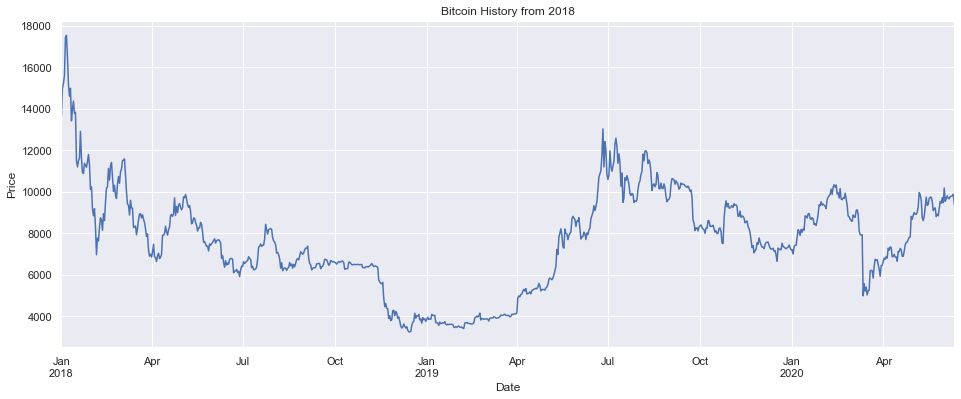

In [19]:
# Lets see our data
plt.figure(figsize=(16,6))
bitcoin.Close.plot()
plt.title('Bitcoin History from 2018')
plt.ylabel('Price');

## Smooth out the data and remove noise

### **savgol_filter**
- will smooth out our data points and make the graph less volatile.

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.savgol_filter.html

In [20]:
# We create a new columns and start with with a 0 int. 
# savgol_filter will smooth out the data 
# polyorder(int) will be how smooth you want the data. (lower = more smooth)/(high = less smooth)
# Window will be the length we want to filter (must be odd int.)
window = 9
bitcoin['smooth'] = savgol_filter(bitcoin.Close, window, polyorder=6)

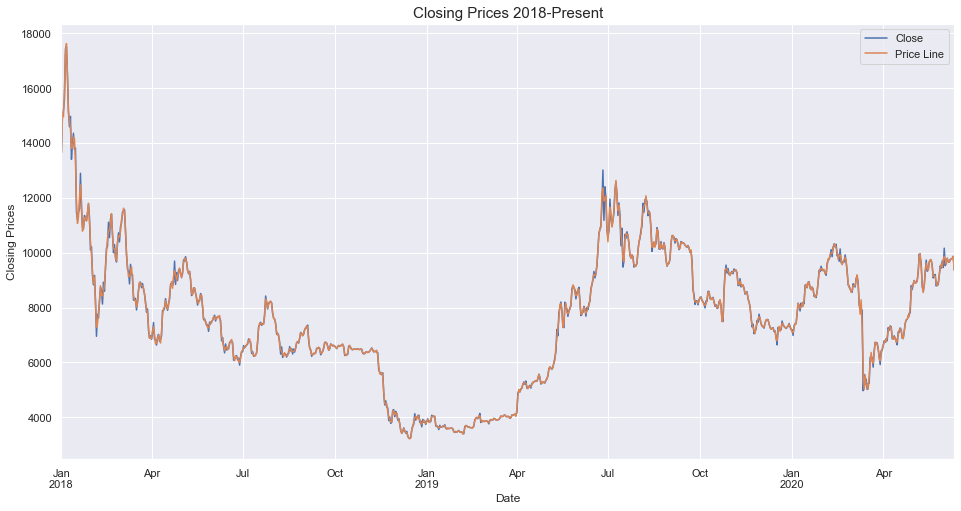

In [21]:
# less sharpness of points and visually less volatile than their original values
plt.figure(figsize=(16,8))
bitcoin.Close.plot()
bitcoin.smooth.plot(label='Price Line')
plt.ylabel('Closing Prices')
plt.title('Closing Prices 2018-Present', fontsize=15)
plt.legend();
# plt.savefig('bitcoin_graph', transparent =True);

In [22]:
# Here we can see that the smooth column is a bit off compared to the Close column. 
# Smooth column represents Close price, but smoother or a bit less stiff
bitcoin.tail()

,Open,High,Low,Close,Volume,smooth,max_ids,min_ids
Date,,,,,,,,
2020-06-07,9653.00,9768.50,9458.15,9758.85,25015250846,9748.628477,0,0
2020-06-08,9760.06,9782.31,9675.89,9771.49,21486346312,9770.915097,0,0
2020-06-09,9774.36,9836.37,9664.72,9795.70,23717842783,9800.363512,0,0
2020-06-10,9794.12,9908.90,9728.29,9870.09,25706567601,9867.507265,1,0
2020-06-11,9870.41,9934.20,9293.31,9364.00,31071213568,9364.479130,0,0


### argrelmin
https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.argrelmin.html
### argrelmax
https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.argrelmax.html#scipy.signal.argrelmax

- argrelmin/max: will find the minima/maxima 
- order is the amount of data points to the left and right. (the amount of adjacent points)

In [23]:
# we will create a new column in the dataframe and set all values to 0
# order: amount of array in which to find the relative minima
# selecting the [0], turns type numpy.ndarray(tuple does not have .tolist meth.). Turn to list type

min_ids = 'min_ids'
max_ids = 'max_ids'
bitcoin[max_ids] = 0
bitcoin[min_ids] = 0

min_id = argrelmin(bitcoin.smooth.values, order=10)[0].tolist()
max_id = argrelmax(bitcoin.smooth.values, order=10)[0].tolist()

# .iloc the min/max and turn them to 1, to indicate if they are low/high price point
# all other data will be 0 if they are not low/high indicators 
bitcoin[min_ids].iloc[min_id] = 1
bitcoin[max_ids].iloc[max_id] = 1

In [24]:
bitcoin.tail(30)

,Open,High,Low,Close,Volume,smooth,max_ids,min_ids
Date,,,,,,,,
2020-05-13,8805.39,9317.88,8805.39,9269.99,45558144023,9340.712191,0,0
2020-05-14,9271.33,9793.27,9255.04,9733.72,56426907637,9618.161966,0,0
2020-05-15,9734.29,9755.83,9261.40,9328.20,48158802327,9419.597483,0,0
2020-05-16,9333.24,9564.21,9260.69,9377.01,36164766407,9357.028834,0,0
2020-05-17,9374.93,9823.00,9349.55,9670.74,40084250662,9643.264157,0,0
2020-05-18,9675.70,9906.03,9570.36,9726.58,41827139895,9752.092960,0,0
2020-05-19,9727.06,9836.05,9539.62,9729.04,39254288954,9738.894336,0,0
2020-05-20,9725.33,9804.79,9447.20,9522.98,36546239702,9469.746169,0,0
2020-05-21,9522.74,9555.24,8869.93,9081.76,39326160532,9141.985291,0,0


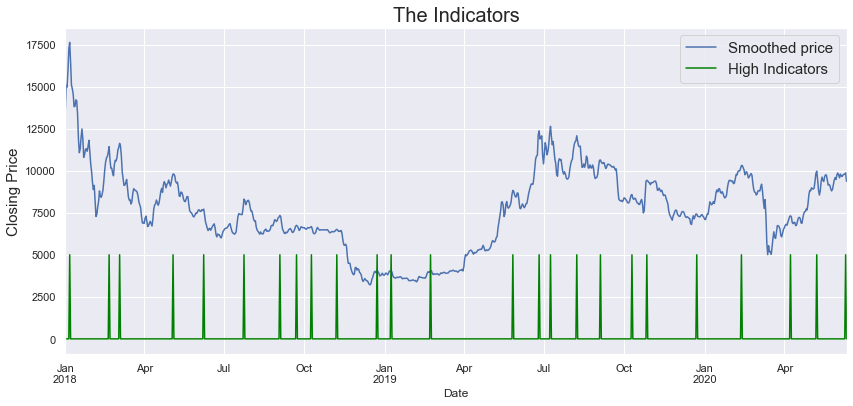

In [25]:
plt.figure(figsize=(14,6))
bitcoin.smooth.plot(label='Smoothed price')
(5000*bitcoin.max_ids).plot(color='green', label='High Indicators')
plt.title('The Indicators', fontsize=20)
plt.ylabel('Closing Price', fontsize=15)
plt.legend(fontsize=15);

# Baseline Model
## LogisticRegression Model: target: max_ids (High Close Price) Best Buy Price

- 'Volume', 'smooth', 'min_ids' will be the only features used
- setting target and feature

In [26]:
features_list = bitcoin.drop(columns=['Open', 'High', 'Low', 'Close', 'max_ids']).columns.tolist()
features_list

['Volume', 'smooth', 'min_ids']

In [27]:
# y is our target
# X is out features list

X = bitcoin[features_list]
y = bitcoin['max_ids']

- using a preprocessor RobustScaler as our scaler. fit in X
- base model is LogisticRegression
- create a pipeline with scaler and model

In [28]:
scaler = preprocessing.RobustScaler().fit(X)
LogReg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs', C=5.0)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='roc_auc')
scores.mean(), scores.std()

(0.7286317752907614, 0.04871140300190309)

In [29]:
# accuracy is very poor at only 53%
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='accuracy')
scores.mean(), scores.std()

(0.5365951313260731, 0.26148956925663314)

----------------------------------------------------------------------------------------------------------

# Feature Engineering

- MACD: Moving Average Convergence Divergence
    - Subtracts the 26-period Expoential Moving Average(EMA) from the 12-period (EMA). 
    - https://www.investopedia.com/terms/m/macd.asp
- Std: of rolling (n)windows
    - this will give us a standard deviation of (n)windows from the mean.
- RSI: Relative Strength Index
    - this is a momentum indicator.
    - the standard period is 14(days)
    - calulates the average gain and lose for a period of time
    - values 0 - 100
    - https://www.investopedia.com/terms/r/rsi.asp
- EWM: Exponential Weighted function
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

In [46]:
# the window we will use is a 5 and 10 day window
# we will find the avg. of these windows and subtract 
windows = [5, 10]

for w in windows:
    rm = bitcoin.Close.rolling(w).mean()
    bitcoin['MACD_'+str(w)] = rm - bitcoin.Close
    bitcoin['Std_'+str(w)] = bitcoin.Close.rolling(w).std()    
    
    
# the rsi_period will be our standard 14 day window
# Out of the 14 day period. We want to know what are the gains and losses
# 1. we will need to know the diff(1) of two diff. days periodically. 
# 2. we use mask to hide any data that is not a gain 
    # - this will hide the losses and 0 changes.
# 3. this is the same for our loss, hide anything that is not a loss

rsi_period = 14
change = bitcoin.Close.diff(1)
gain = change.mask(change<0,0)
loss = change.mask(change>0,0)

# here we use EWM to find the gain/loss with a period of time
# min_periods: will be our standard 14 day period
# com: is the period that we want to weight in
    # - we want to use the 14 day period, but compare the avg. gain/loss to the original close price
    # - hence why we subtract 1, taking the initial closing price out of the equation since we are
    # using it as a comparison
# we will do this for the gain and loss averages.
avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()

# here we find the absolute value of the relative strength for the gain and loss
rs = abs(avg_gain/avg_loss)

# this is the equation/math for RSI
# we will subtract it from 100 since the scale is 0-100.
rsi = 100 - (100/(1+rs))
bitcoin['RSI'] = rsi

# after finding and creating a new RSI column, we will drop all NANs
clean_bit = bitcoin.dropna()

In [47]:
clean_bit.shape
# we did lose a bit of information from dropping NaNs, but that's okay.

(879, 13)

### Setting up a binary classifier for RSI

In [48]:
# here we create new columns to help us identify if the RSI is >=70 or <=30
# initially we just want the columns to be all 0, we will change this later
# we call upon the new column and .loc the 'RSI' with a bool statement
# if the statement is True then we will identify it as a 1, if not then it will remain a 0

rsi_70 = 'RSI_70'
rsi_30 = 'RSI_30'
clean_bit[rsi_70] = 0
clean_bit[rsi_30] = 0
clean_bit[rsi_70].loc[bitcoin['RSI'] >=70] = 1
clean_bit[rsi_30].loc[bitcoin['RSI'] <=30] = 1

In [50]:
clean_bit.head()

,Open,High,Low,Close,Volume,smooth,max_ids,min_ids,MACD_5,Std_5,MACD_10,Std_10,RSI,RSI_70,RSI_30
Date,,,,,,,,,,,,,,,
2018-01-15,13767.3,14445.5,13641.70,13819.8,12750799872,13333.435431,0,0,47.88,346.448830,988.38,1303.213114,44.798209,0,0
2018-01-16,13836.1,13843.1,10194.90,11490.5,18853799936,11871.682906,0,0,1994.12,1138.429177,2714.03,1301.979900,31.936412,0,0
2018-01-17,11431.1,11678.0,9402.29,11188.6,18830600192,11070.617638,0,0,1737.62,1470.607260,2487.03,1349.403135,30.705902,0,0
2018-01-18,11198.8,12107.3,10942.50,11474.9,15020399616,11306.710723,0,0,874.26,1326.252496,1831.21,1399.695246,33.329375,0,0
2018-01-19,11429.8,11992.8,11172.10,11607.4,10740400128,11982.881740,0,0,308.84,1075.223039,1399.91,1412.753560,34.564115,0,0


## High Close Predictions + New Features

- created a new lis of new features and drop conflicting columns
- apply new features list to X and set y
- copy and paste the same model and run code for updated results

In [53]:
# for the high, we're going to switch our the y(target)
features_list2 = clean_bit.drop(columns=['Open', 'High', 'Low', 'Close', 'max_ids']).columns.tolist()
features_list2

['Volume',
 'smooth',
 'min_ids',
 'MACD_5',
 'Std_5',
 'MACD_10',
 'Std_10',
 'RSI',
 'RSI_70',
 'RSI_30']

In [55]:
X = clean_bit[features_list2]
y = clean_bit['max_ids']

In [56]:
scaler = preprocessing.RobustScaler().fit(X)
LogReg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs', C=5.0)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='roc_auc')
scores.mean(), scores.std()

(0.827318532169131, 0.0684886816468928)

In [57]:
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='accuracy')
scores.mean(), scores.std()

(0.8124169779991698, 0.1153297577577509)

- we can see here that our accuracy had improved. 81% from the original 53%
- our auc score also improved from 73% to 83%

### Graphing Predictions

- collect the predictions from the model, and append to dataframe 

In [58]:
high_preds = cross_val_predict(pipe, X, y, n_jobs=-1, cv=5)
clean_bit['high_preds'] = high_preds.tolist()

- graph the labels and the target 

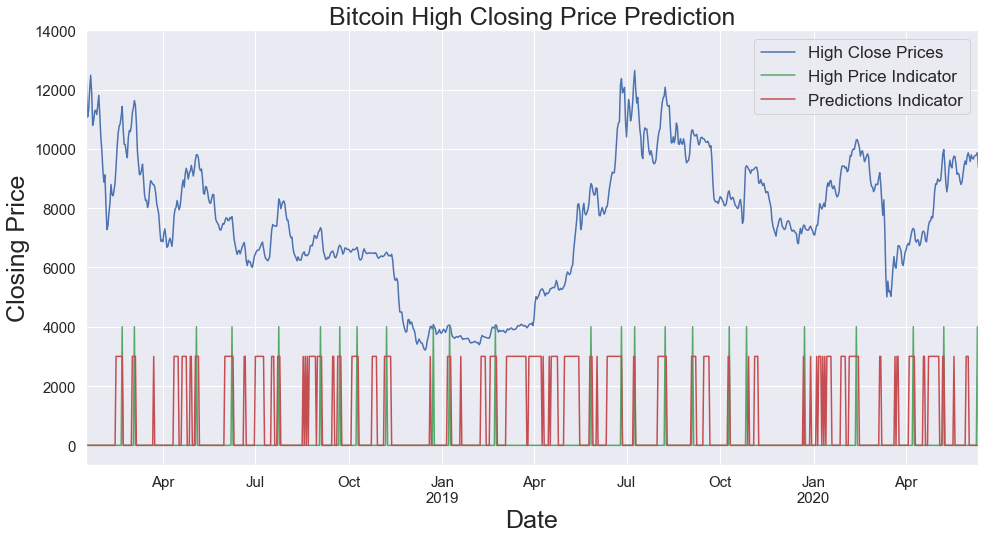

In [79]:
plt.figure(figsize=(16,8))

clean_bit.smooth.plot(label='High Close Prices')

(4000*clean_bit.max_ids).plot(color='g', label='High Price Indicator') # scaled up to 4000, this is the label
(3000*clean_bit.high_preds).plot(color='r', label='Predictions Indicator') # scaled up to 3000, this is the predictions

plt.ylabel('Closing Price', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Bitcoin High Closing Price Prediction', fontsize=25)
plt.legend(fontsize=17);
# plt.savefig('High_Closing_Price_Prediction', transparent =True);

- the model did miss some high points for the true highs
- but it also found some similar highs on the graph

          - Optimized Model LogisticRegression                  - Base Model LogisticRegression
            accuarcy score: 83%                                   accuarcy score: 73%
            roc_auc score: 81%                                    roc_auc score: 53%         

#### Results may differ due to updated data each day of this date May 5, 2020

## Summary

- The data collected was from Yahoo Finance, this data was already sorted for us.
- Changed our data to datetime so we can use it as a time series.
- Baseline model returned poor results, and our optimized model improved that score.

Improvements:
- Altering the window of days and will alot more accuracy. 
- The initial data can be expanded from 2018.
- Steep slows are hard to predict on. Our model has failed to accomodate for the rapid price change. Need to find a way to fix this problem. 